In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
import joblib

### Apply data preprocessing

In [27]:
with open('./featureSelection.pkl', 'rb') as file:
    feature_selection = pickle.load(file)

print(feature_selection)
feature_selection = np.append(feature_selection, ' Label')

df = pd.read_csv('./TER20.csv')
sample = df.sample(n=100)
sample = sample[feature_selection]

['fl_dur' 'fw_pk' 'l_fw_pkt' 'l_bw_pkt' 'pkt_len_min' 'pkt_len_max'
 'pkt_len_std' 'bw_iat_tot' 'bw_iat_min' 'bw_psh_flag']


### Minority Removal

In [28]:
# merging labels to four cats
target = ' Label'
classes_to_merge = {
            # four minority classes
            "DDos": ["NetBIOS_DDoS", "Portmap_DDoS", "MSSQL_DDoS", "LDAP_DDoS"],
            # 3 remainder
            "Botnet": ["Botnet", "Web Attack", "Backdoor"]
        #  other two classes are Syn_DDoS and UDP_DDoS 
        }
sample['merged_label'] = sample[target].apply(lambda x: next((key for key, value in classes_to_merge.items() if x in value), x))
sample.drop(columns=[target], inplace=True)
sample.rename(columns={'merged_label': target}, inplace=True)

label_counts = sample[target].value_counts()
label_counts_df = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values})
print("Step 2: Four different cats in label: ") 
print(label_counts_df)

Step 2: Four different cats in label: 
      Label  Count
0      DDos     50
1    Botnet     31
2  Syn_DDoS     11
3  UDP_DDoS      8


### Random Forest 

In [29]:
# features
X = sample.drop(columns=target)
# labels (4)
y = sample[target].to_numpy()
rf = RandomForestClassifier(max_depth=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [30]:

s = pickle.dumps(rf)
joblib.dump(s, "./RF.pkl")


['./RF.pkl']

In [46]:
with open('./RF.pkl', 'rb') as file:
    s = pickle.load(file)

rf2 = pickle.loads(s)
rf2

c:\Users\rsoza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\rsoza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


RandomForestClassifier(max_depth=20, random_state=42)

In [56]:
rf2.

1

In [32]:
original_accuracy = accuracy_score(y_test, y_pred)

print(f"Original Accuracy: {original_accuracy}")


Original Accuracy: 0.9


### Plot important features

fl_dur         0.141418
fw_pk          0.021780
l_fw_pkt       0.264227
l_bw_pkt       0.025283
pkt_len_min    0.287915
pkt_len_max    0.250005
pkt_len_std    0.000000
bw_iat_tot     0.004188
bw_iat_min     0.005184
bw_psh_flag    0.000000
dtype: float64


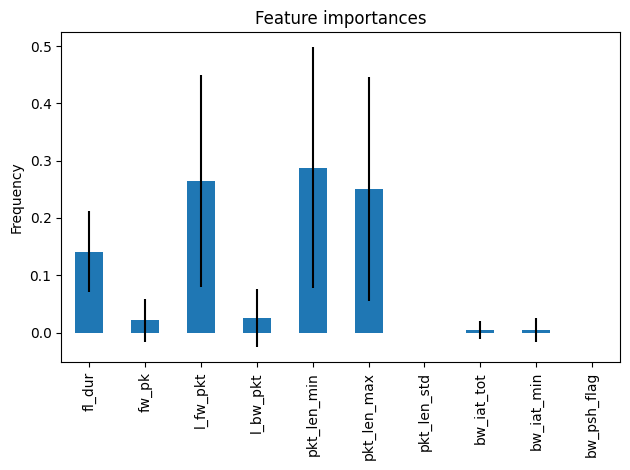

In [33]:
feature_names = [f"{X.columns[i]}" for i in range(X.shape[1])]
importance = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importance, index=feature_names)
print(forest_importances)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Frequency")
fig.tight_layout()

In [40]:
X_test['pkt_len_min'] = np.random.rand(len(X_test['pkt_len_min']))
y_adv_pred = rf2.predict(X_test)
adversarial_accuracy = accuracy_score(y_test, y_adv_pred)

In [44]:
y_adv_pred

array(['DDos', 'DDos', 'UDP_DDoS', 'DDos', 'DDos', 'DDos', 'Syn_DDoS',
       'Botnet', 'DDos', 'UDP_DDoS', 'DDos', 'Syn_DDoS', 'DDos', 'DDos',
       'DDos', 'DDos', 'DDos', 'DDos', 'UDP_DDoS', 'DDos'], dtype=object)

In [45]:
y_test

array(['DDos', 'DDos', 'UDP_DDoS', 'Botnet', 'DDos', 'DDos', 'Syn_DDoS',
       'Botnet', 'Botnet', 'UDP_DDoS', 'Botnet', 'Syn_DDoS', 'DDos',
       'DDos', 'Botnet', 'DDos', 'DDos', 'DDos', 'UDP_DDoS', 'DDos'],
      dtype=object)

In [42]:
print(f"Original prediction: {y_pred[1]}")
print(f"Adversarial prediction: {y_adv_pred[1]}")
print(f"Original Accuracy: {original_accuracy}")
print(f"Adversarial Accuracy: {adversarial_accuracy}")

Original prediction: Botnet
Adversarial prediction: DDos
Original Accuracy: 0.9
Adversarial Accuracy: 0.8
